# Join Projections

<br/>

<pre>
model name:            imagenette_128_resnet18_model.pth
network architecture:  resnet18
dataset:               imagenette training set
image size:            128x128 (resized beforehand)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagenette dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagenette dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

The first step of our OoD detection method is executed before inference. Here we measure in-distribution statistics from the training data and OoD statistics from the calibration data. Both kind of statistics are necessary to calculate the credibility of a test sample at inference. 

After fetching from the data samples (see __01_fetch_activations_imagenette_128_resnet18.ipynb__), vectorizing these activations (see __02_vectorize_activations_imagenette_128_resnet18.ipynb__) and receiving their projections (see __03_get_projections_imagenette_128_resnet18.ipynb__) we join the projections of the individual layers in a Python dictionary. We do this because it is more convenient in the following to use a single dictionary containing the projections of all layers than a dictionary for each individual layer. As the projections are much smaller than the activations we will not run into memory issues.

<br/>

_Sources:_
* [Imagenette dataset](https://github.com/fastai/imagenette)
* [Deep kNN paper](https://arxiv.org/abs/1803.04765)
* [Deep kNN sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py)
* [Deep kNN sample code (PyTorch)](https://github.com/bam098/deep_knn/blob/master/dknn_mnist.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
from pathlib import Path
import random
import warnings
import pprint
from collections import Counter

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Projections
img_size          = 128                                                             # Image size
base_projs_folder = Path('/Users/lehmann/research/laca3/projections/imagenette')    # Base projection folder
pfname_string     = 'imagenette_{}_resnet18_projs'.format(img_size)                 # Projections file name
projs_path        = base_projs_folder/pfname_string                                 # Activations path
layer_names       = [                                                               # List of layer names 
    'relu',
    'maxpool',
    'layer1-0',
    'layer1-1',
    'layer2-0',
    'layer2-1',
    'layer3-0',
    'layer3-1',
    'layer4-0',
    'layer4-1',
    'avgpool'
]

## Define Function for Plotting Projections

In [4]:
def plot_projects(projections, cluster_labels=None, cluster_centers=None):
    layers = list(projections['projections'].keys())
    
    for layer_name in layers:        
        df = pd.DataFrame()
        df['x'] = projections['projections'][layer_name][:,0]
        df['y'] = projections['projections'][layer_name][:,1]
        
        if cluster_labels is not None:
            df['targets'] = cluster_labels[layer_name]
        else:
            df['targets'] = projections['targets']
    
        plot = sns.lmplot(
            x='x', y='y', data=df, fit_reg=False, hue='targets', height=8, palette='muted', legend=False,
            scatter_kws={'marker': 'D', 's': 50, 'alpha': 0.6}
        ).set_axis_labels('x1','x2')
    
        if cluster_labels is not None:
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers[layer_name]), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)
    
        fig = plot.fig
        fig.suptitle('Projections from Layer {}'.format(layer_name), y=1.025, fontsize = 20)

## Join Projections

In [5]:
train_projections = {}
train_projections['projections'] = {}
train_projections['targets'] = None
train_projections['scaler'] = {}
train_projections['reducer'] = {}


for layer_name in layer_names:
        
    # Load projections
    fname = str(projs_path) + '_{}_{}.pkl'.format('trainset', layer_name)
    with open(fname, 'rb') as pickle_file:
        loaded_train_projections = pickle.load(pickle_file)
       
    # Store projections, scaler, reducer and targets in dict
    train_projections['projections'][layer_name] = loaded_train_projections['projections']
    train_projections['scaler'][layer_name] = loaded_train_projections['scaler']
    train_projections['reducer'][layer_name] = loaded_train_projections['reducer']
        
    if loaded_train_projections['targets'] is not None:
        if train_projections['targets'] is not None:
            np.testing.assert_array_equal(loaded_train_projections['targets'], train_projections['targets'])
        else:
            train_projections['targets'] = loaded_train_projections['targets']

In [6]:
print('targets: {}'.format(train_projections['targets'].shape))
print()

for layer_name in layer_names:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(train_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(train_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(train_projections['reducer'][layer_name]))
    print()

targets: (9469,)

## layer relu
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric

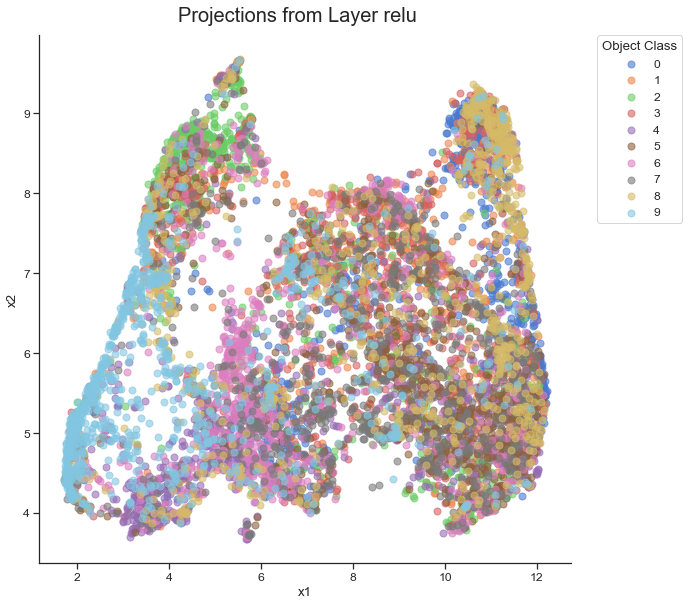

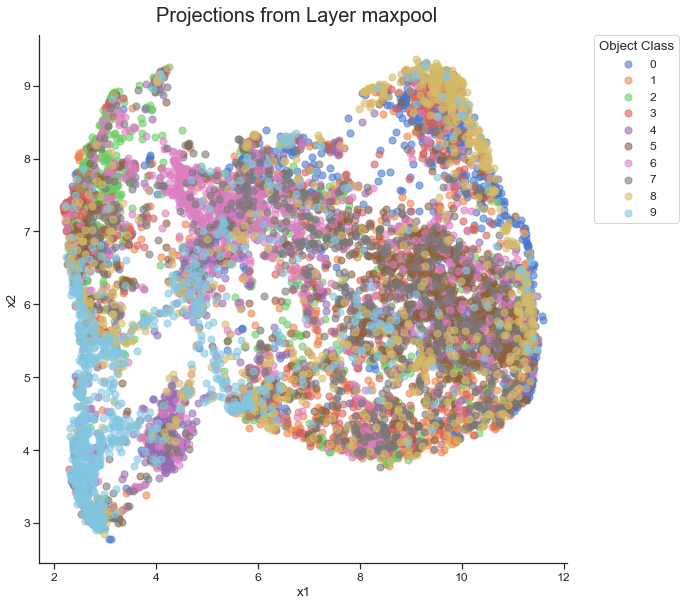

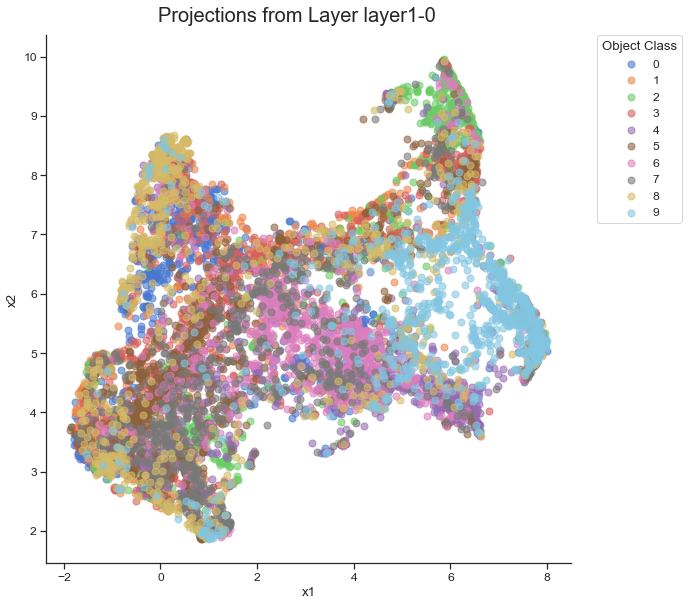

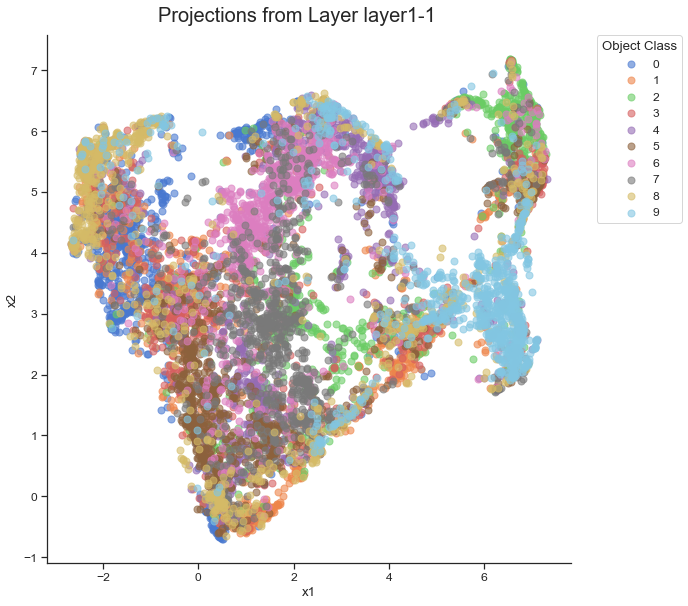

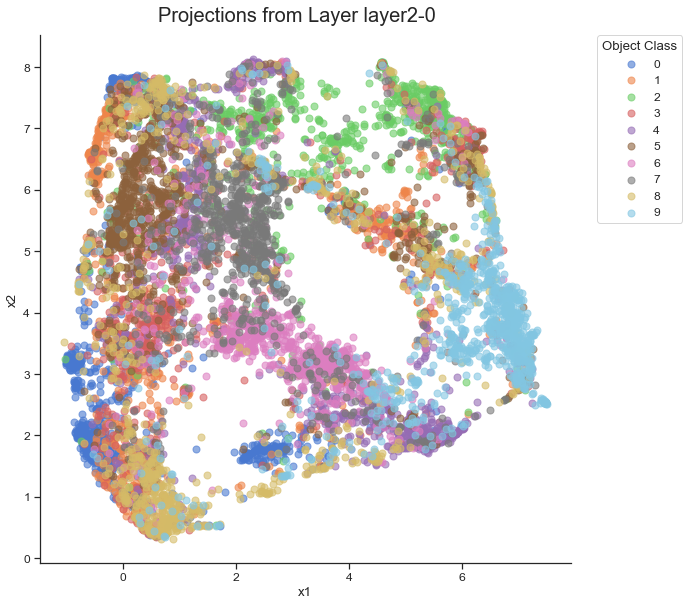

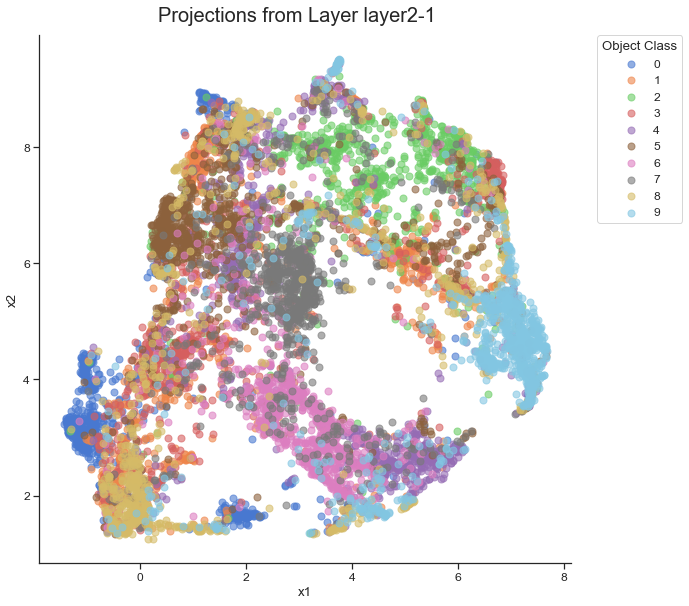

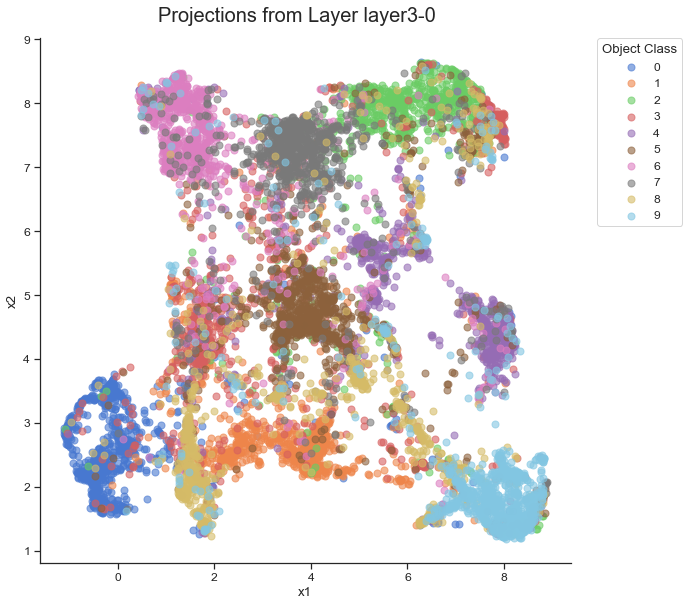

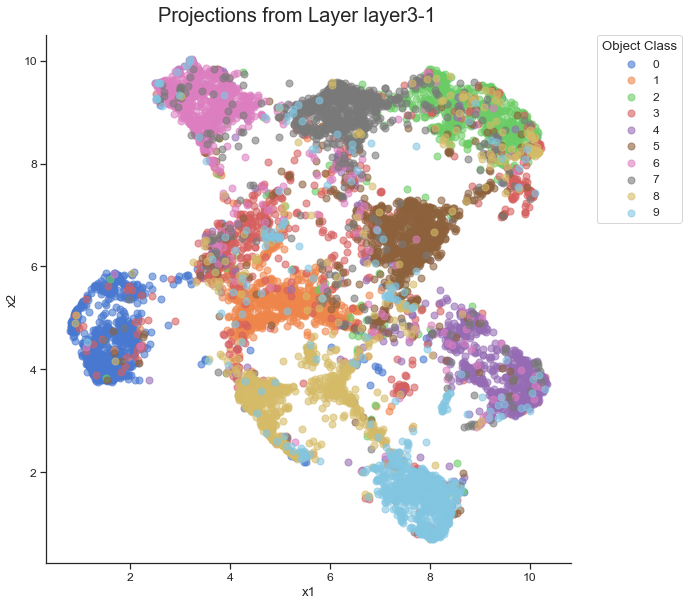

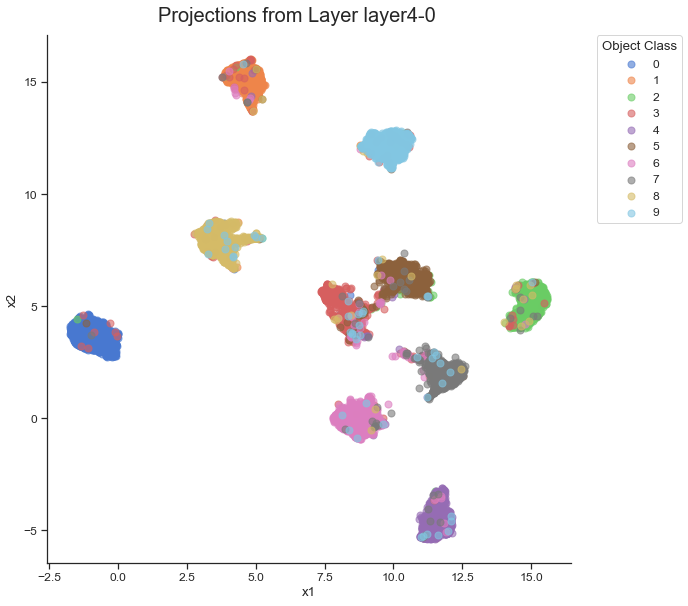

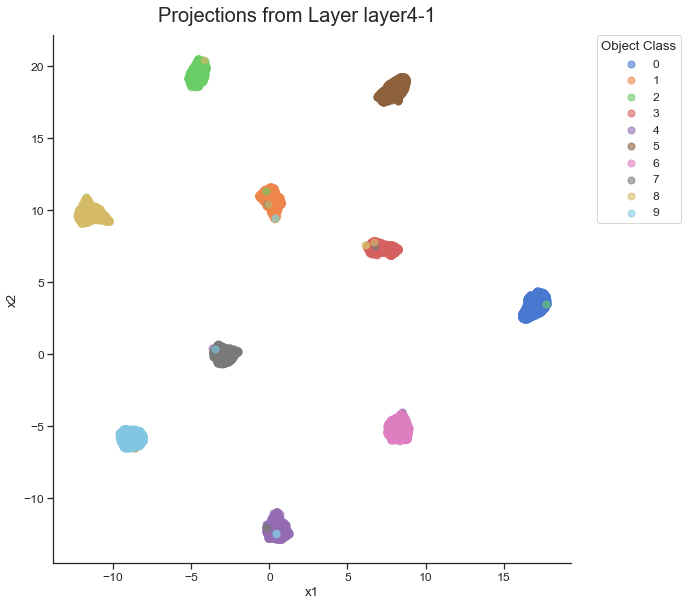

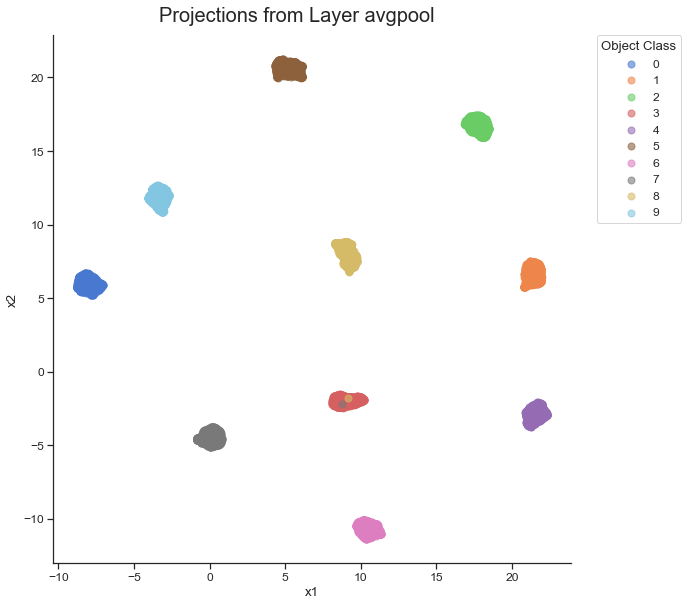

In [7]:
plot_projects(train_projections)

## Store Projections

In [8]:
fname = str(projs_path) + '_{}_all.pkl'.format('trainset')
with open(fname, 'wb') as pickle_file:
    pickle.dump(train_projections, pickle_file)

In [9]:
fname = str(projs_path) + '_{}_all.pkl'.format('trainset')
with open(fname, 'rb') as pickle_file:
    loaded_train_projections = pickle.load(pickle_file)

In [10]:
print('targets: {}'.format(loaded_train_projections['targets'].shape))
print()

for layer_name in layer_names:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(loaded_train_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(loaded_train_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(loaded_train_projections['reducer'][layer_name]))
    print()

targets: (9469,)

## layer relu
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric

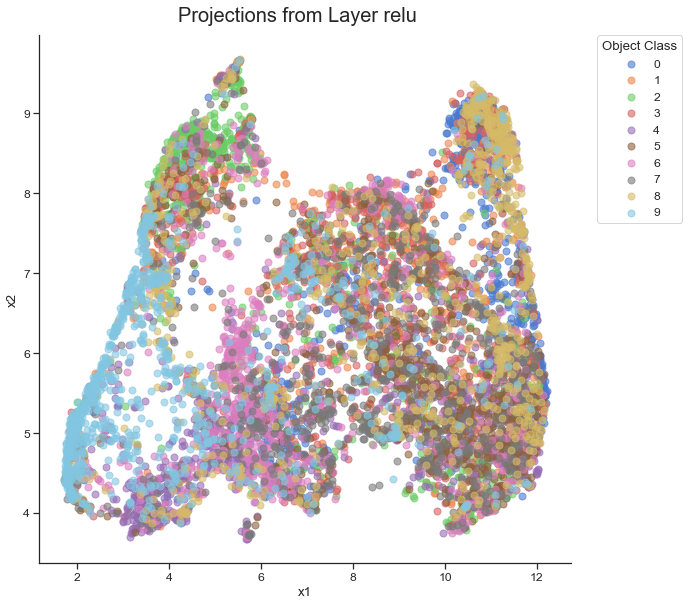

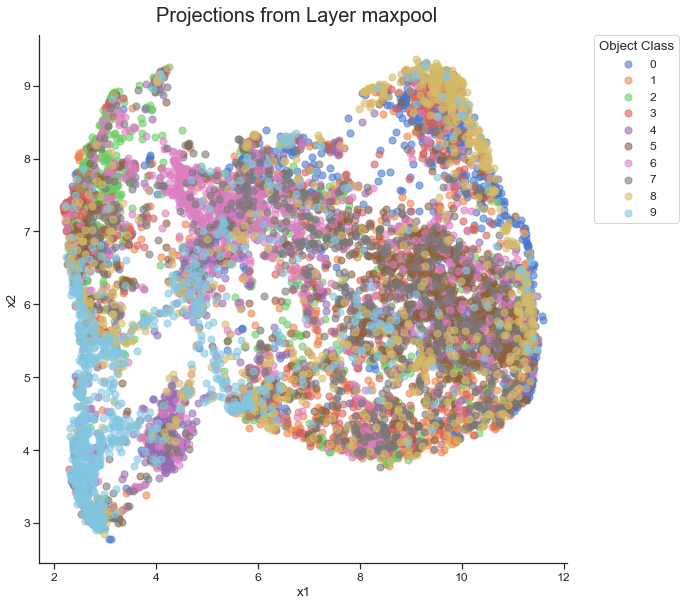

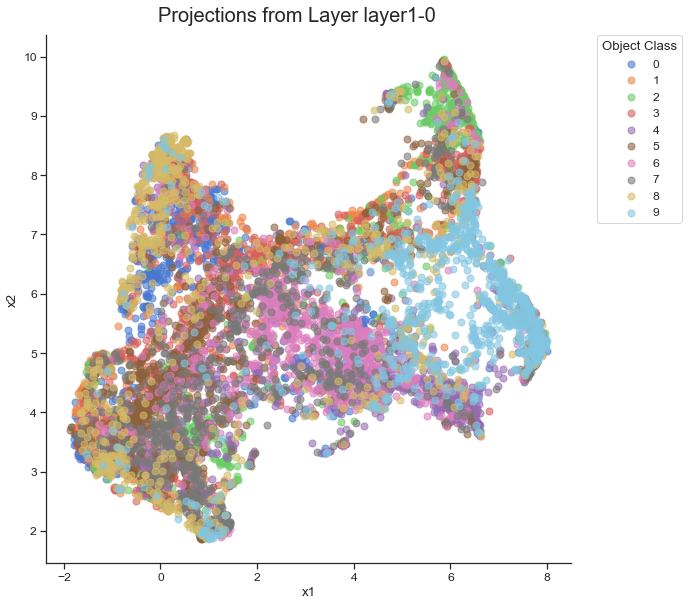

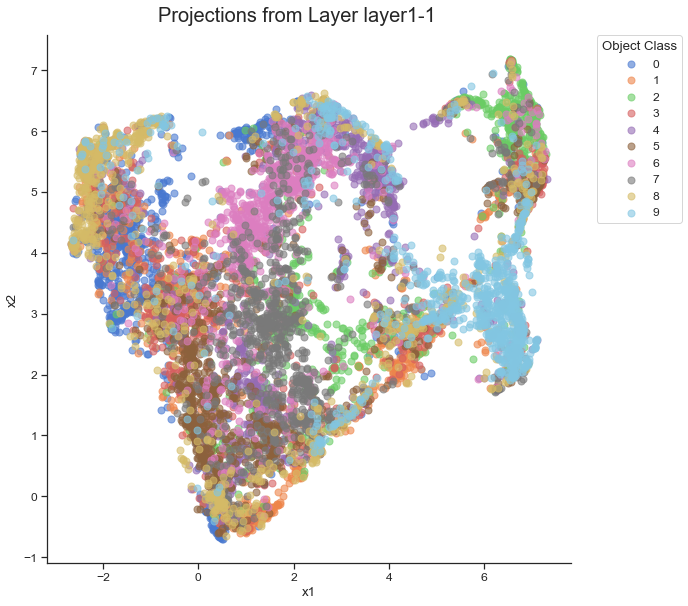

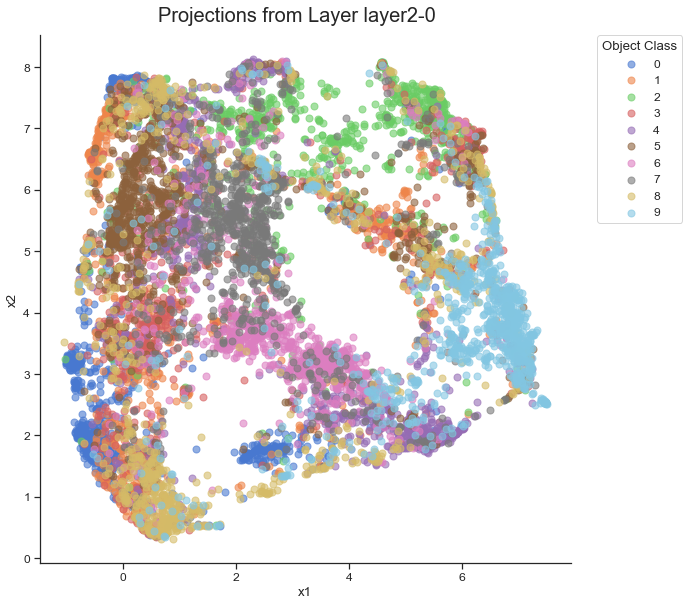

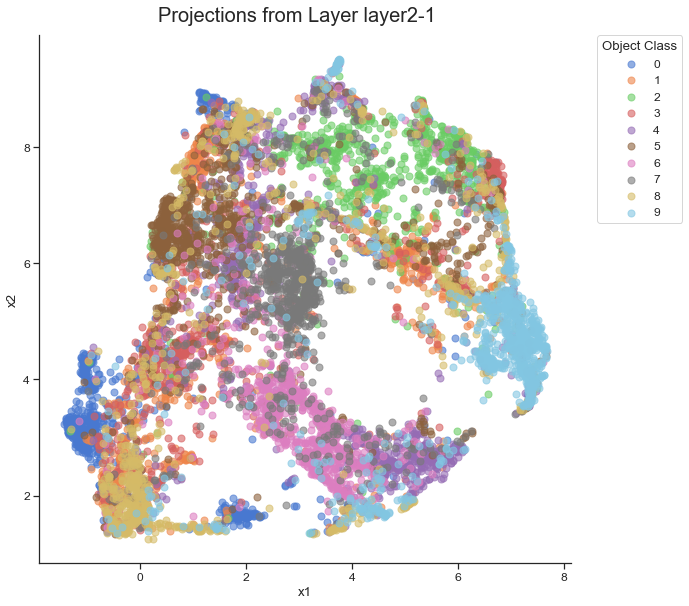

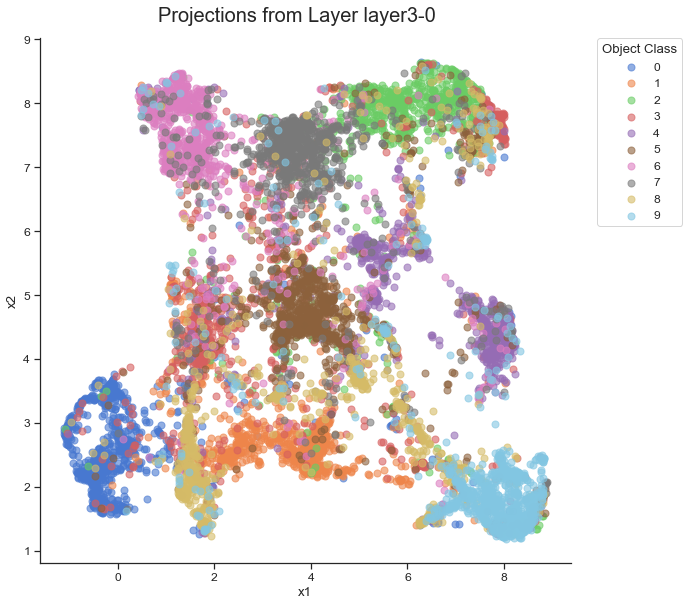

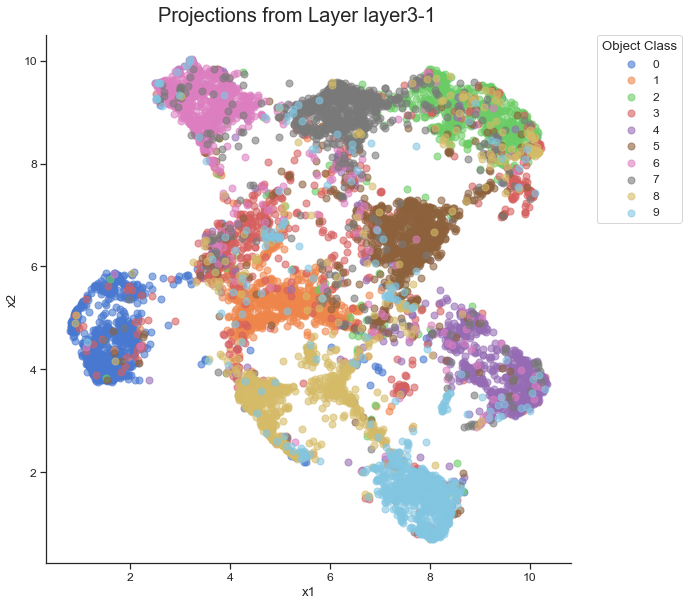

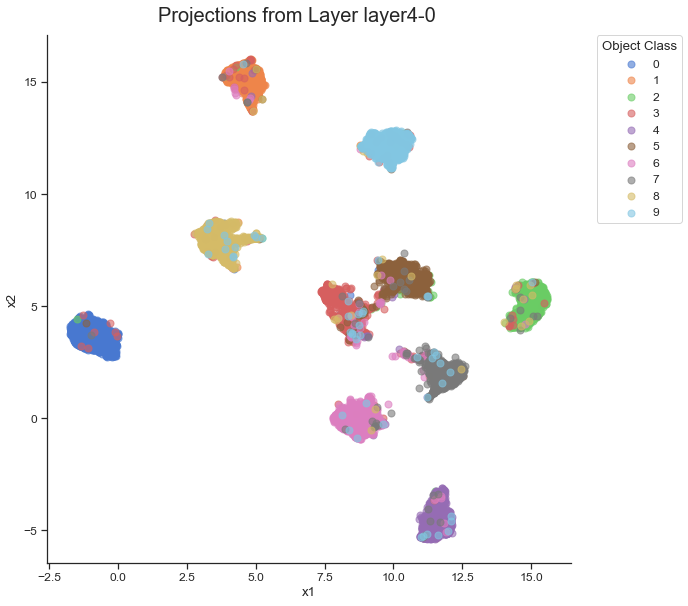

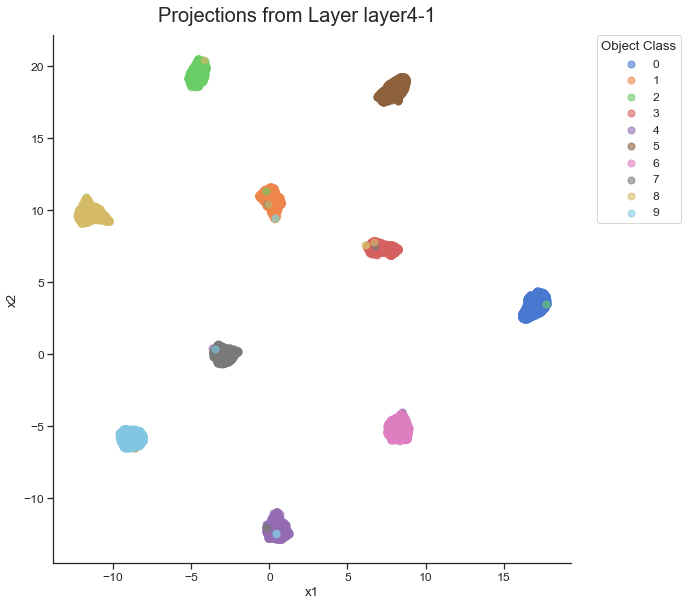

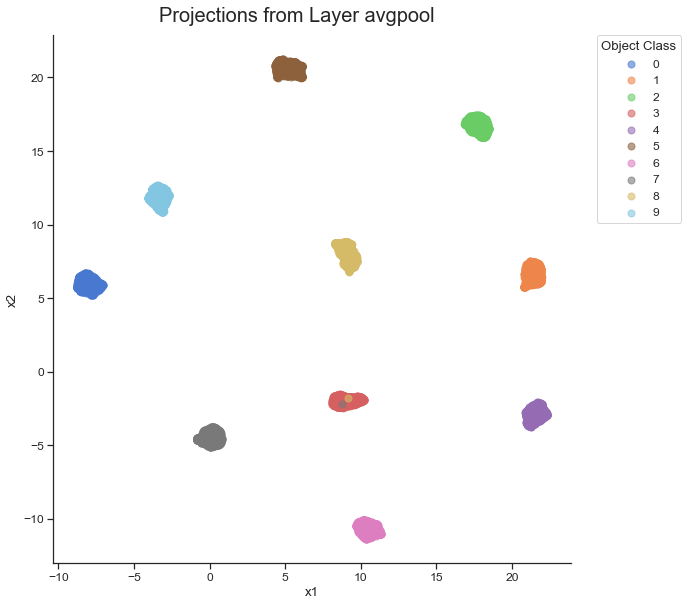

In [11]:
plot_projects(loaded_train_projections)